# 1.) Imports 

In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from pandas import date_range
from statsmodels.graphics.tsaplots import plot_pacf
from glob2 import glob
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

# Model 1 (trend)
#from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import RegressorChain
import warnings

In [4]:
# switch off the warnings
warnings.filterwarnings("ignore")

# 2.) Read Data

In [5]:
csv_files = glob('../Final Project/*.csv')

In [6]:
col_list = ['FlightDate', 'Airline', 'Origin', 'Dest', 'DepDelayMinutes']

dfs = []
for file in csv_files:
    dfs.append(pd.read_csv(file, usecols=col_list))
df = pd.concat(dfs).reset_index(drop=True)

In [7]:
df.head(5)

,FlightDate,Airline,Origin,Dest,DepDelayMinutes
0,2019-04-01,Envoy Air,LIT,ORD,0.0
1,2019-04-02,Envoy Air,LIT,ORD,0.0
2,2019-04-03,Envoy Air,LIT,ORD,0.0
3,2019-04-04,Envoy Air,LIT,ORD,143.0
4,2019-04-05,Envoy Air,LIT,ORD,4.0


In [9]:
#create date data and decreasing memory by converting variables to categorical types
df['FlightDate'] = pd.to_datetime(df['FlightDate'])

df['Year'] = df['FlightDate'].dt.year
df['Month'] = df['FlightDate'].dt.month
cat_cols = ['Airline', 'Origin', 'Dest']
df[cat_cols] = df[cat_cols].astype('category')
df.head(5)
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29193782 entries, 0 to 29193781
Data columns (total 7 columns):
 #   Column           Dtype         
---  ------           -----         
 0   FlightDate       datetime64[ns]
 1   Airline          category      
 2   Origin           category      
 3   Dest             category      
 4   DepDelayMinutes  float64       
 5   Year             int64         
 6   Month            int64         
dtypes: category(3), datetime64[ns](1), float64(1), int64(2)
memory usage: 1.0 GB


(29193782, 7)

In [10]:
df_delay = df[df.DepDelayMinutes != 0]
df_delay = df_delay.sort_values(by = ['FlightDate'])
df_delay.head(10)

,FlightDate,Airline,Origin,Dest,DepDelayMinutes,Year,Month
8353621,2018-01-01,Southwest Airlines Co.,ATL,HOU,315.0,2018,1
8338296,2018-01-01,SkyWest Airlines Inc.,DEN,MFR,10.0,2018,1
8338297,2018-01-01,SkyWest Airlines Inc.,MTJ,DEN,16.0,2018,1
8338298,2018-01-01,SkyWest Airlines Inc.,BHM,ORD,NaN,2018,1
8338300,2018-01-01,SkyWest Airlines Inc.,DEN,MKE,15.0,2018,1
8338306,2018-01-01,SkyWest Airlines Inc.,DCA,ORD,103.0,2018,1
8338307,2018-01-01,SkyWest Airlines Inc.,CHS,ORD,59.0,2018,1
8338308,2018-01-01,SkyWest Airlines Inc.,DEN,AUS,39.0,2018,1
8338309,2018-01-01,SkyWest Airlines Inc.,SFO,SBA,29.0,2018,1
8338311,2018-01-01,SkyWest Airlines Inc.,FCA,DEN,10.0,2018,1


## Count of Delays by Year

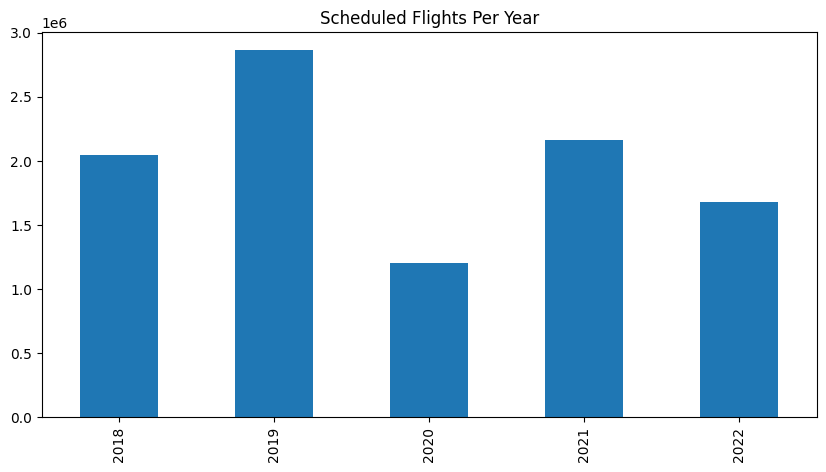

In [11]:
#count of flights per year
df_delay["Year"].value_counts().sort_index().plot(
    kind="bar", figsize=(10, 5), title="Scheduled Flights Per Year"
)
plt.show()

# 3.) Visualize Data

Now we want to get the number of delays for each date, and plot the dependency of delay on date

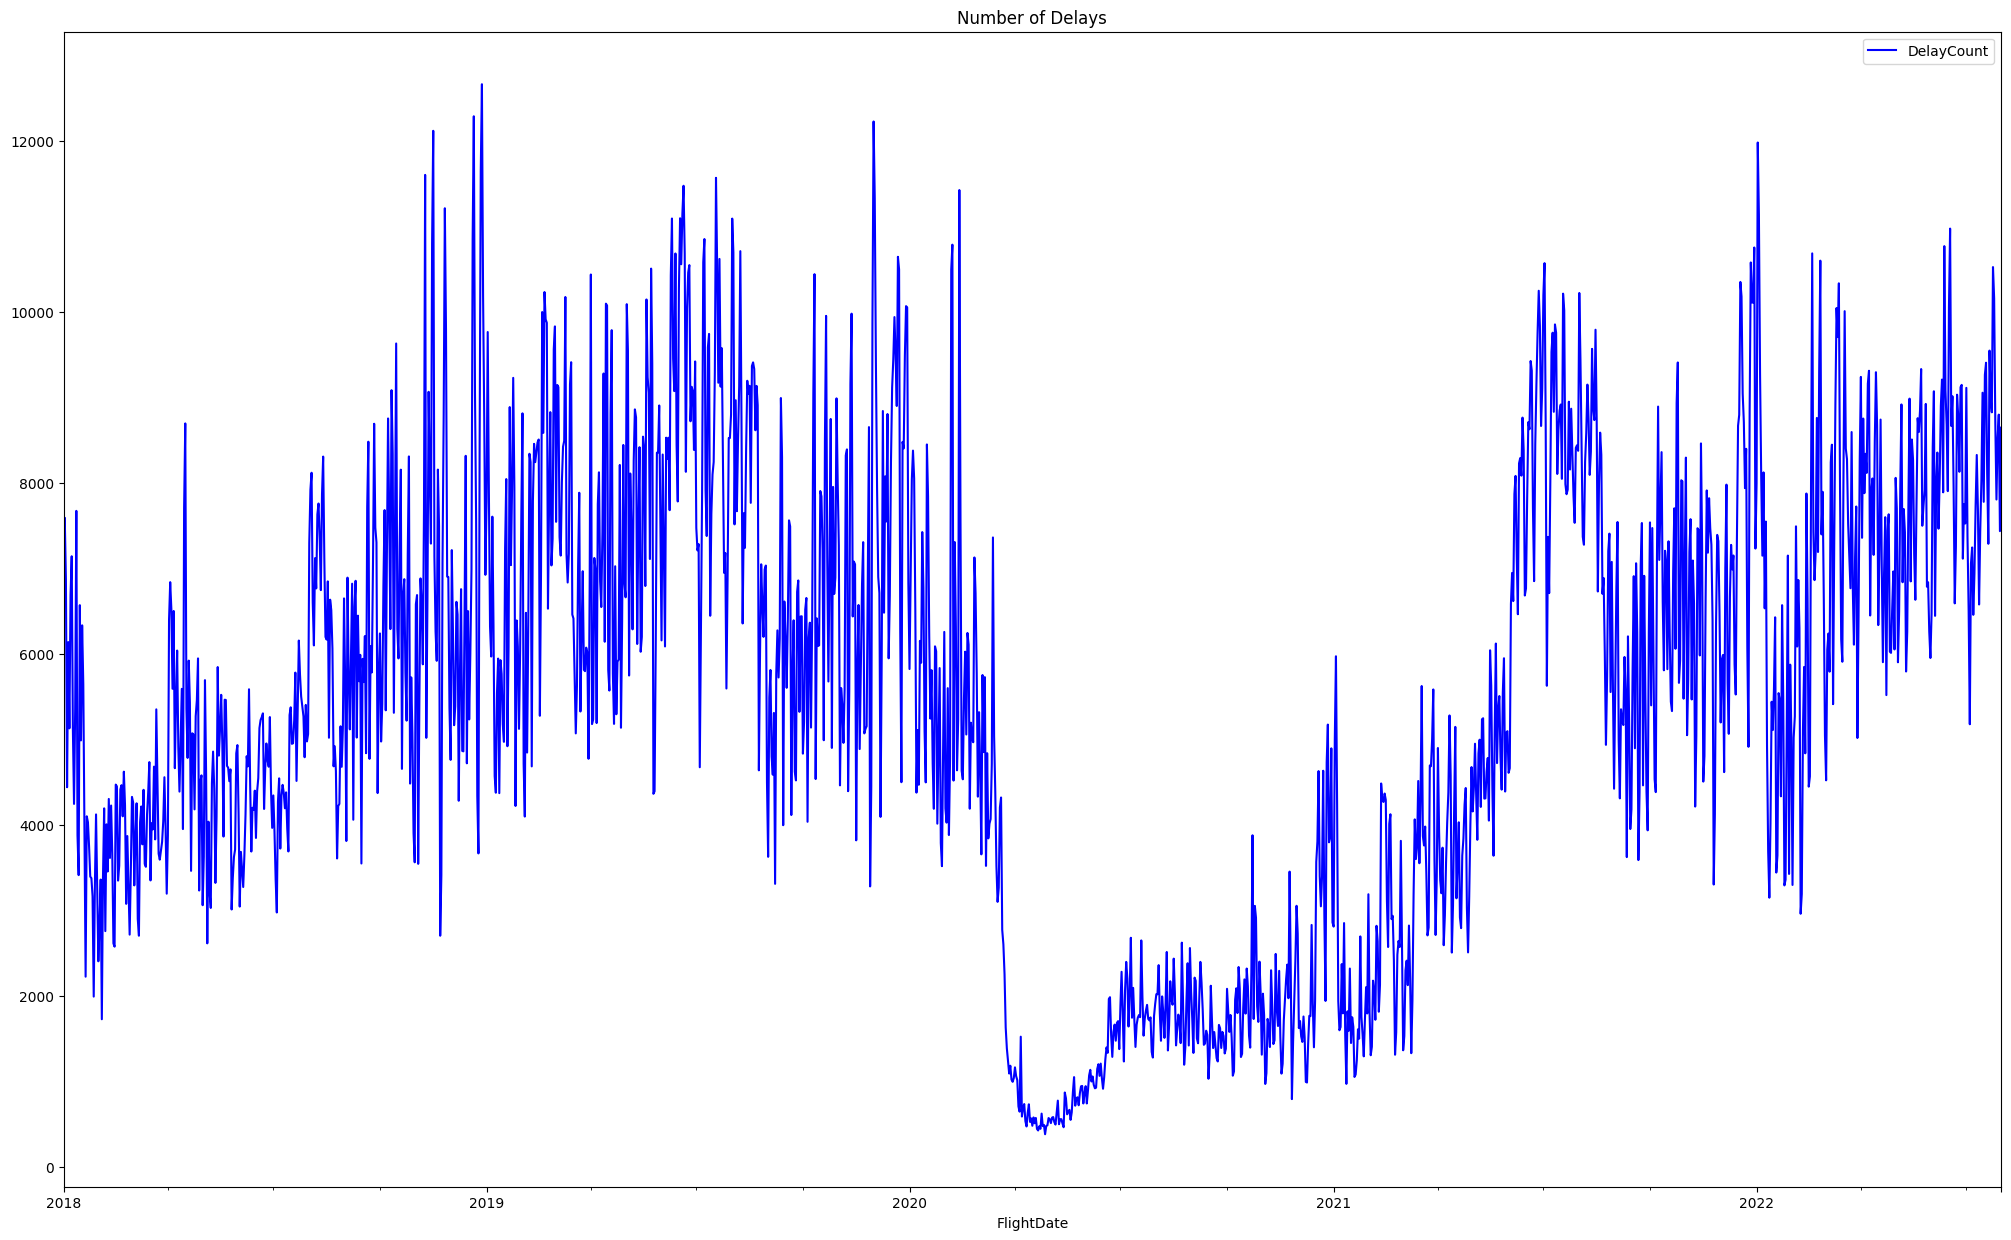

In [13]:
sc = df_delay.resample('D', on='FlightDate')['DepDelayMinutes'].count()
sc =sc.rename('DelayCount')
sv = df_delay.resample('D', on='FlightDate')['DepDelayMinutes'].sum()
sv = sv.rename('MinutesDelayed')
s = pd.concat([sv,sc], axis=1)
s.head(10)
#ts_df = pd.DataFrame(s)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
s.plot.line(y="DelayCount", color='b', title ="Number of Delays", ax = axes, rot=0)
plt.show()

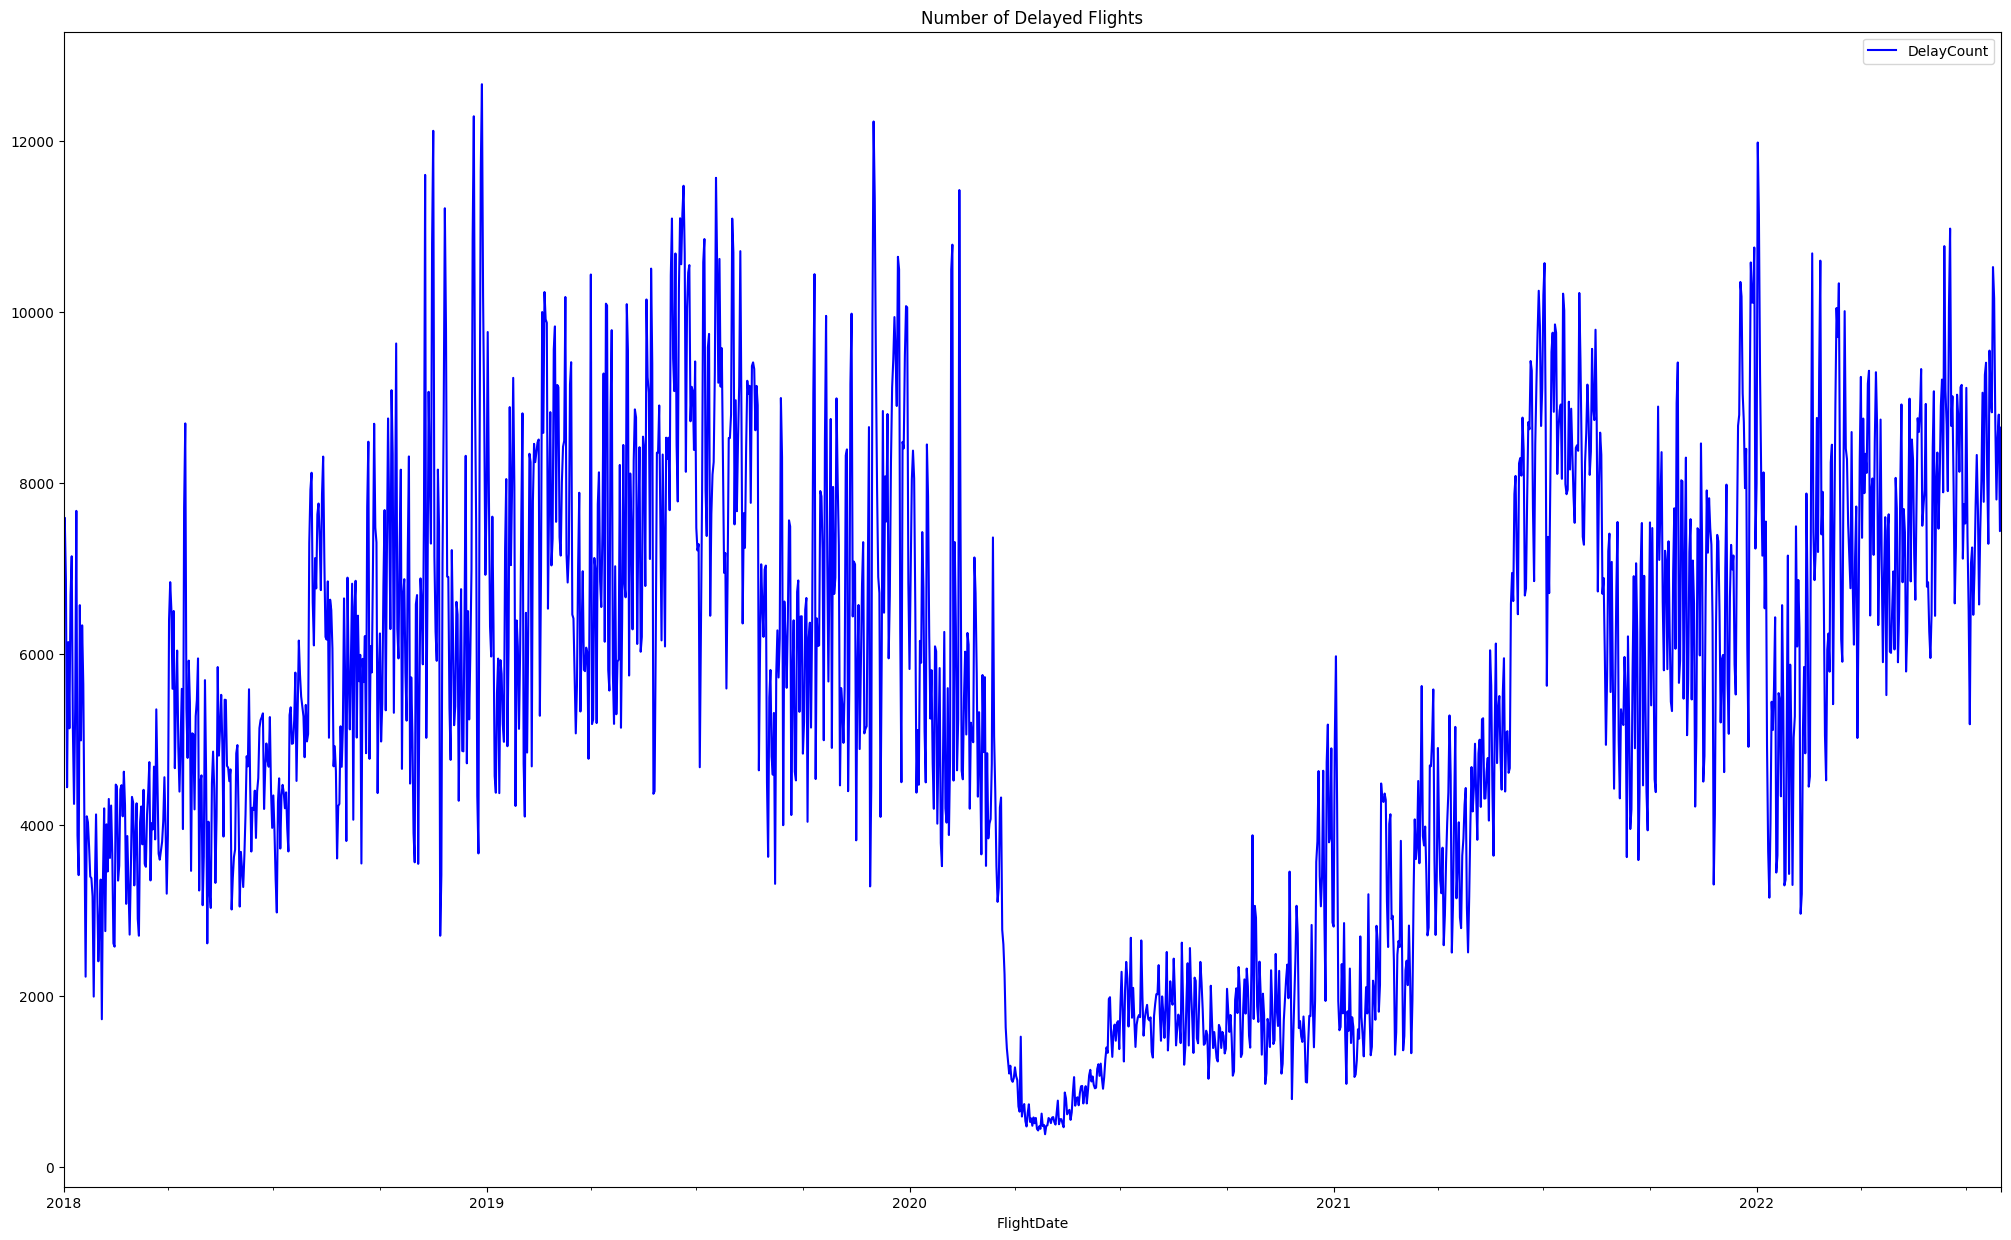

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
s.plot.line(y="DelayCount", color='b', title ="Number of Delayed Flights", ax = axes, rot=0)
plt.show()

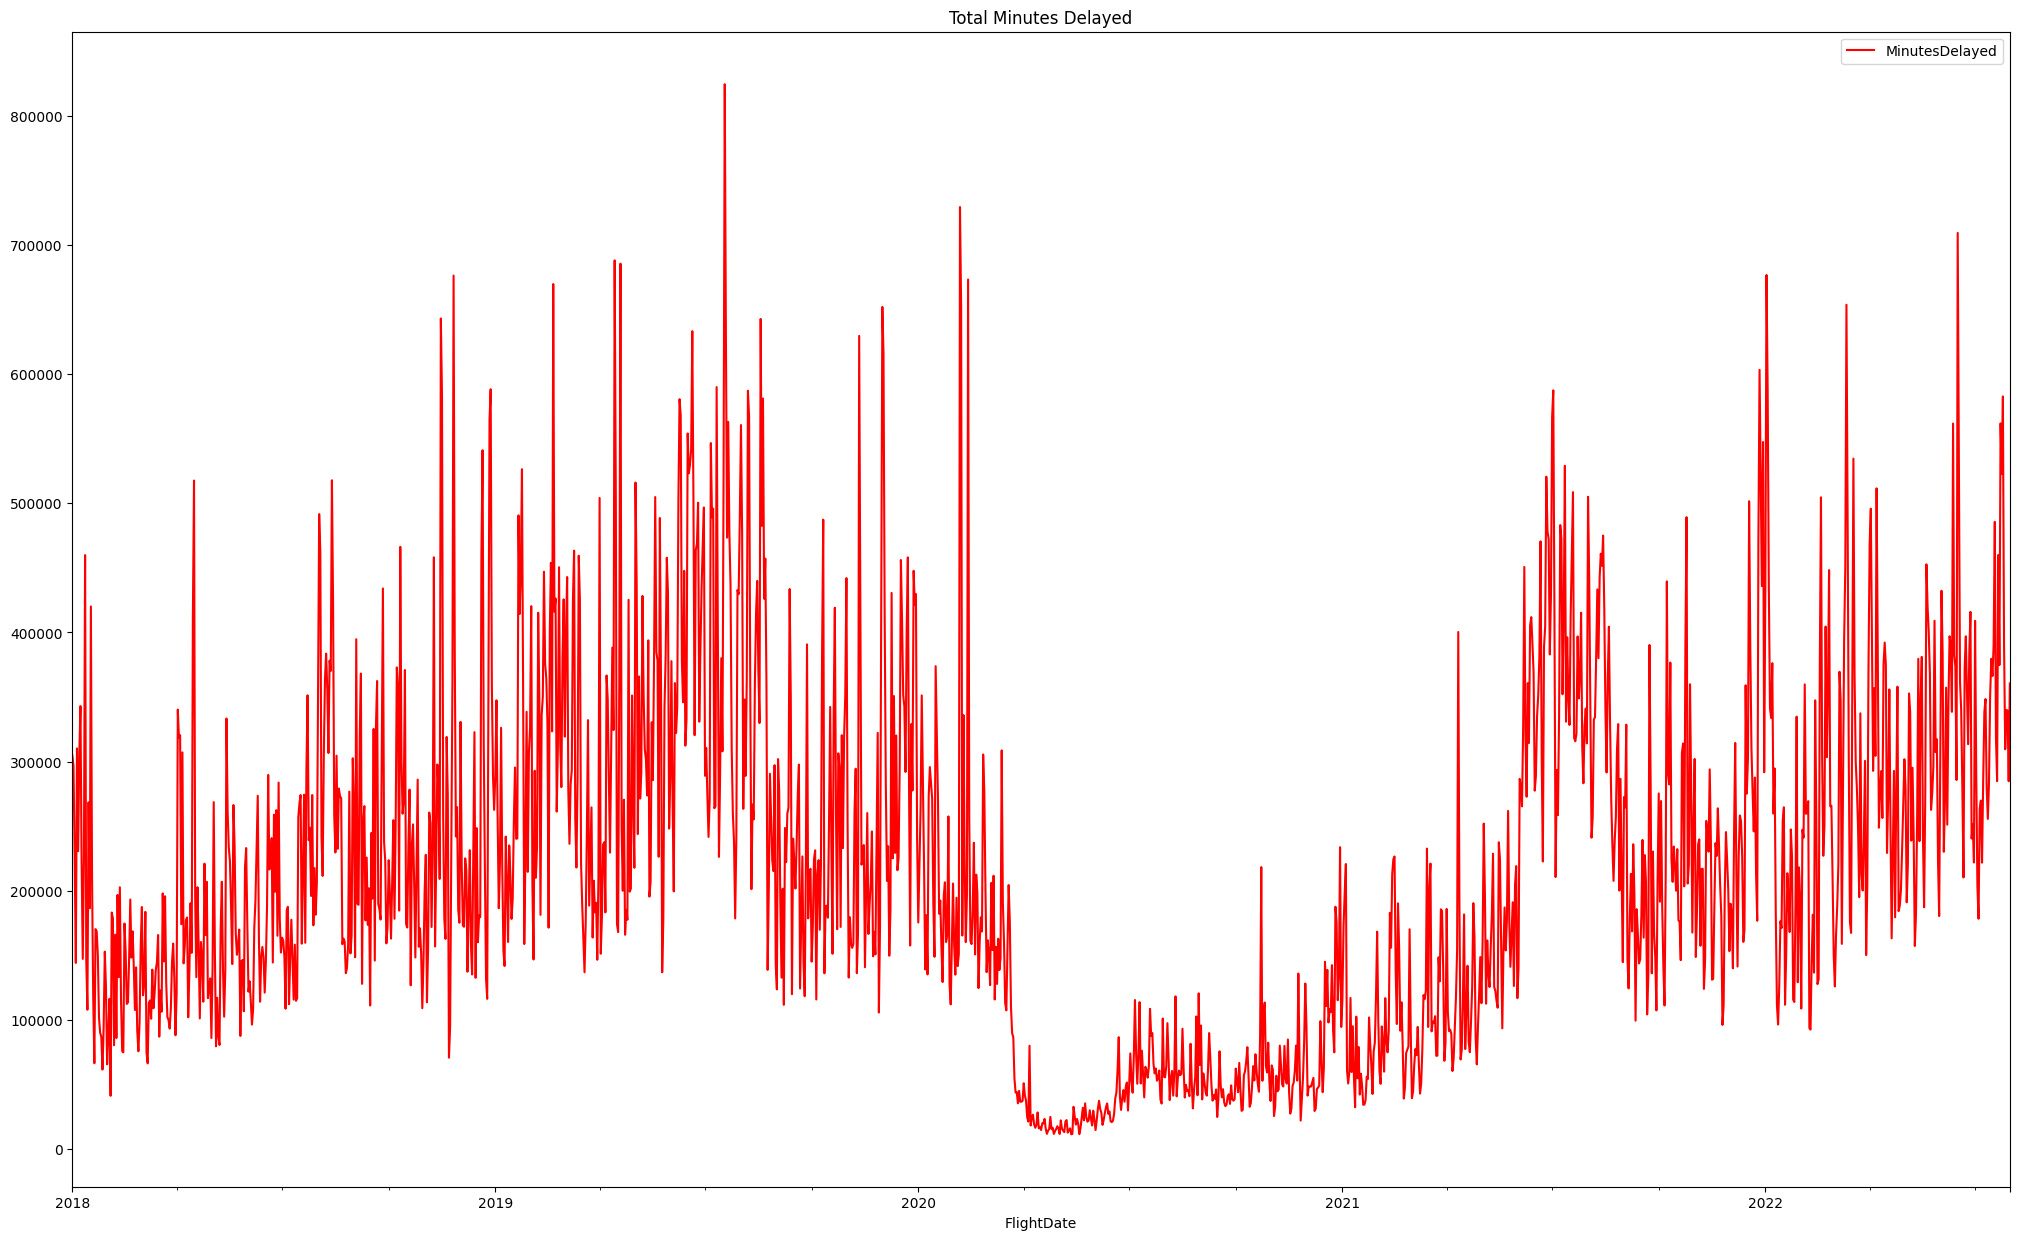

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
s.plot.line(y="MinutesDelayed", color='r', title ="Total Minutes Delayed", ax = axes, rot=0)
plt.show()

In [18]:
# Below I will filter the data down to just Chicago ORD and create an ARMA model.
df_ord = df[df['Origin']=='ORD']
df_ord.head()


,FlightDate,Airline,Origin,Dest,DepDelayMinutes,Year,Month
208,2019-04-01,Envoy Air,ORD,MSP,0.0,2019,4
209,2019-04-02,Envoy Air,ORD,MSP,5.0,2019,4
210,2019-04-03,Envoy Air,ORD,MSP,0.0,2019,4
211,2019-04-04,Envoy Air,ORD,MSP,0.0,2019,4
212,2019-04-05,Envoy Air,ORD,MSP,5.0,2019,4


In [20]:
# Count total flights per day
flights_per_day_ORD = df_ord.resample('D', on='FlightDate')['DepDelayMinutes'].count()
flights_per_day_ORD = flights_per_day_ORD.rename('TotalFlights')
flights_per_day_ORD.head()




FlightDate
2018-01-01    551
2018-01-02    596
2018-01-03    575
2018-01-04    497
2018-01-05    560
Freq: D, Name: TotalFlights, dtype: int64

In [26]:
# Get the total delays per day for ORD
df_ord_delay = df_ord[df_ord['DepDelayMinutes']>30]
delays_per_day_ORD = df_ord_delay.resample('D', on='FlightDate')['DepDelayMinutes'].count()
delays_per_day_ORD = delays_per_day_ORD.rename('TotalFlights')
delays_per_day_ORD.head()

# Merge the two dataframes and calc the delay rate
delays_per_day_ORD = delays_per_day_ORD.rename('TotalDelays')
ord = pd.concat([flights_per_day_ORD,delays_per_day_ORD], axis=1)

ord['DelayRate'] = ord['TotalDelays']/ord['TotalFlights']
ord.head()


,TotalFlights,TotalDelays,DelayRate
FlightDate,,,
2018-01-01,551,198,0.359347
2018-01-02,596,180,0.302013
2018-01-03,575,153,0.266087
2018-01-04,497,66,0.132797
2018-01-05,560,113,0.201786


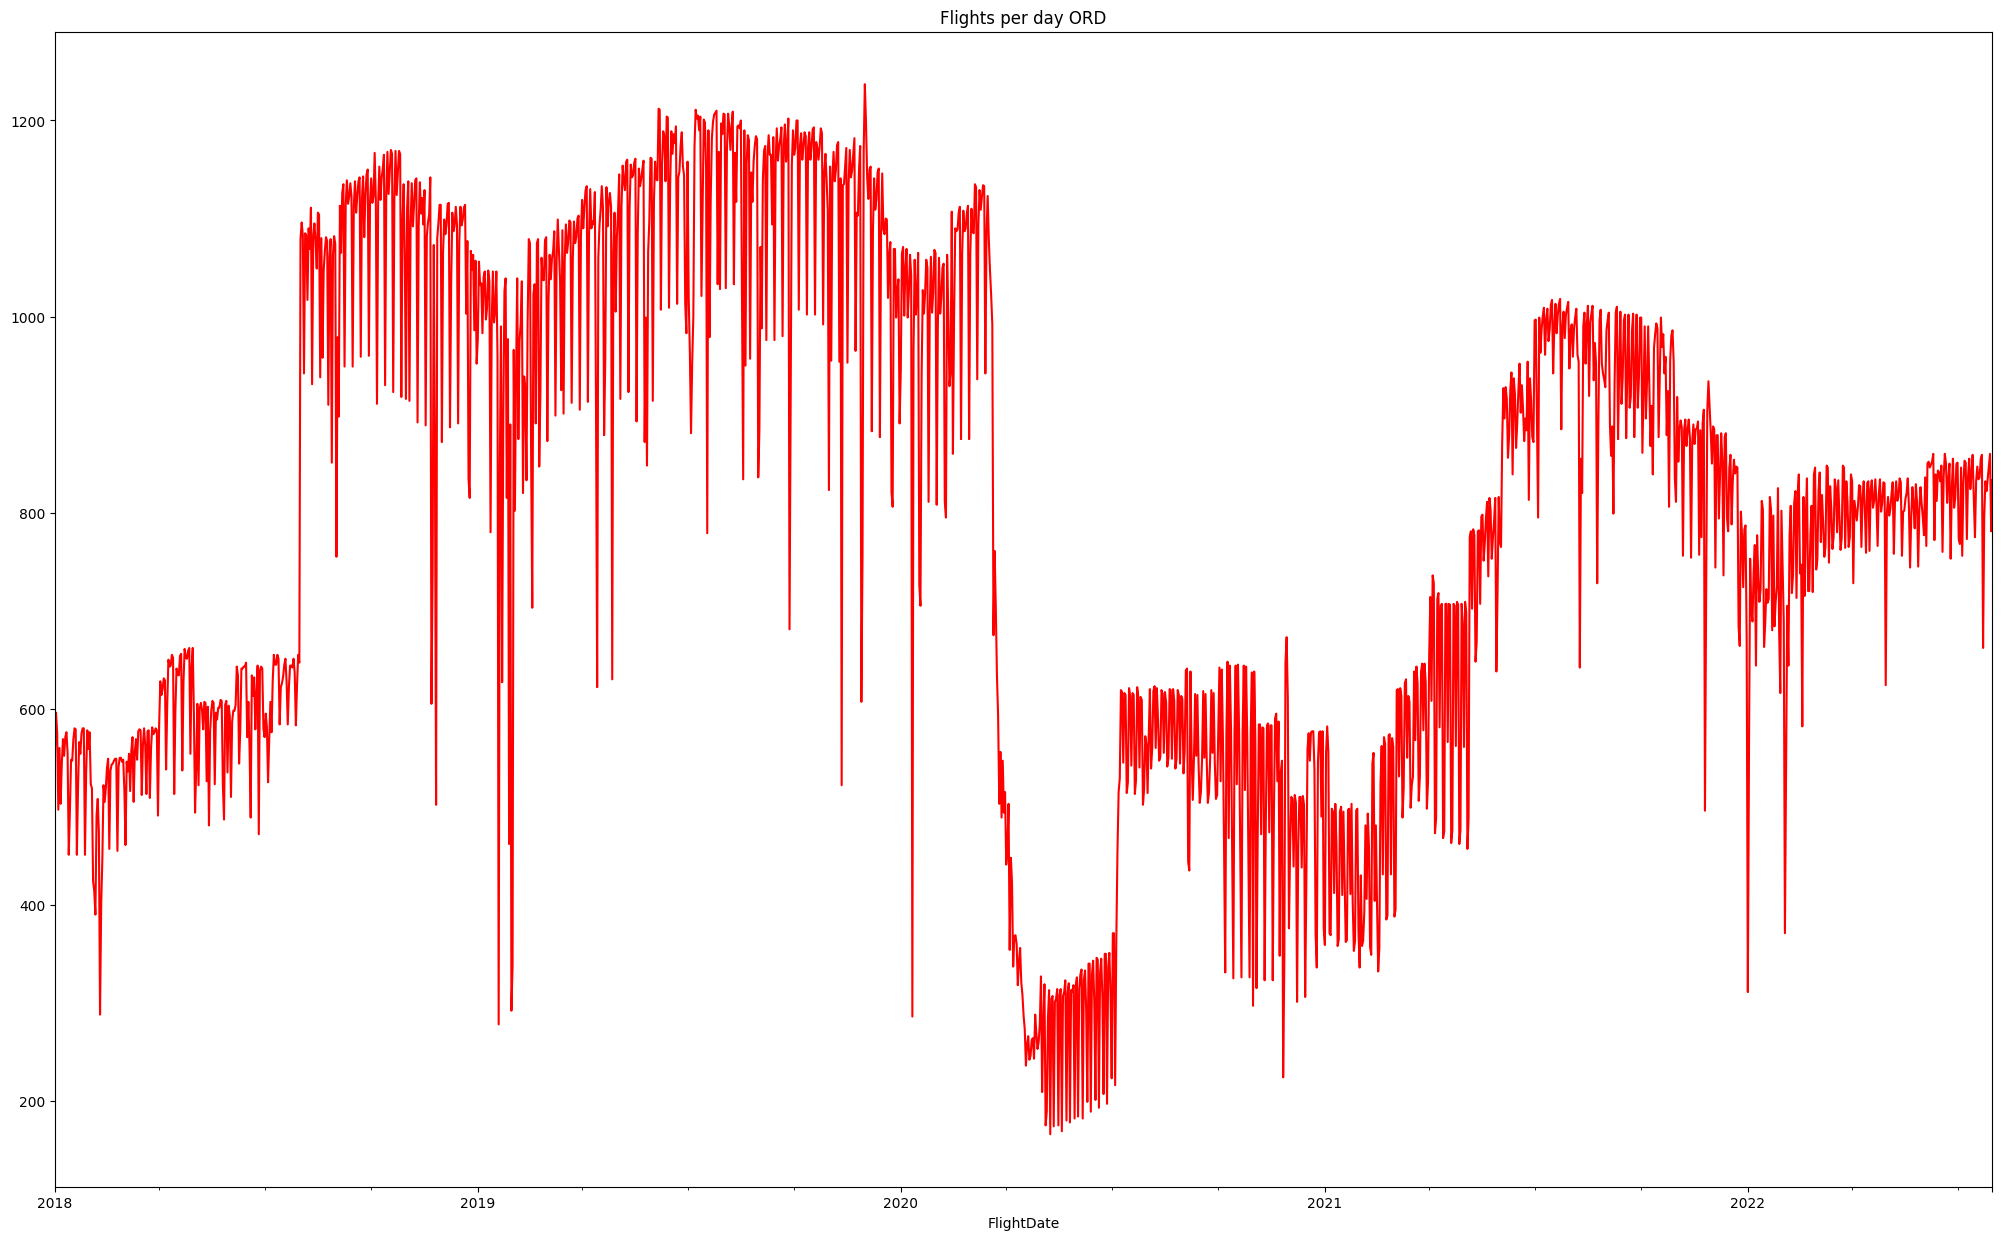

In [21]:
# Plot Flights per day 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
flights_per_day_ORD.plot.line(y="TotalFlights", color='r', title ="Flights per day ORD", ax = axes, rot=0)
plt.show()

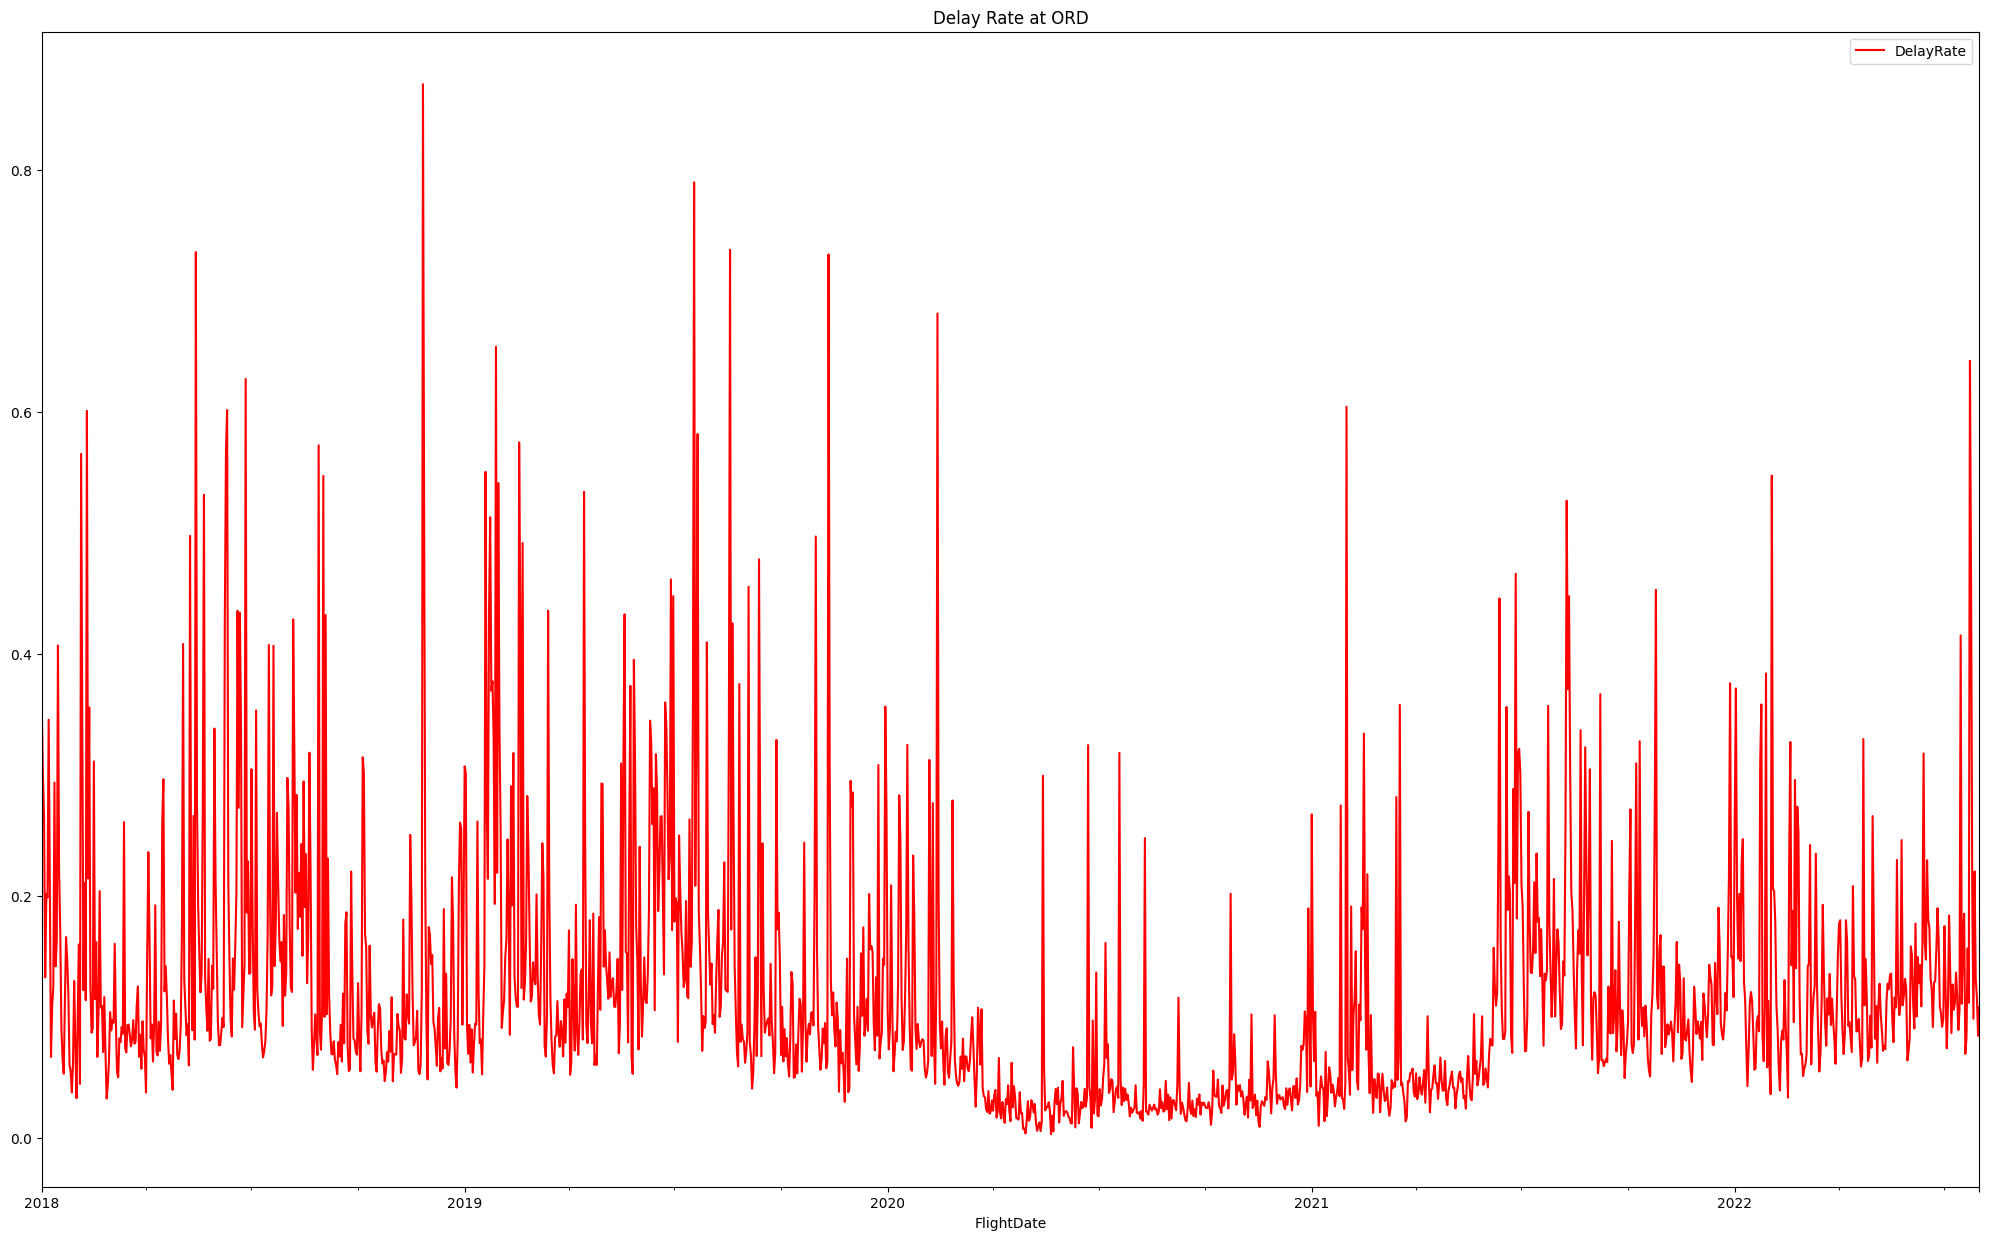

In [27]:
# Plot Flights per day 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
ord.plot.line(y="DelayRate", color='r', title ="Delay Rate at ORD", ax = axes, rot=0)
plt.show()

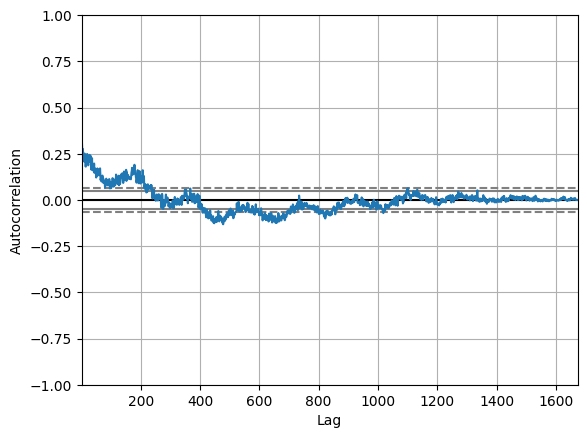

In [28]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot

# Generate an autocorrelation plot
autocorrelation_plot(ord['DelayRate'])
pyplot.show()

                               SARIMAX Results                                
Dep. Variable:              DelayRate   No. Observations:                 1673
Model:                 ARIMA(7, 2, 7)   Log Likelihood                1599.570
Date:                Mon, 10 Apr 2023   AIC                          -3169.141
Time:                        22:36:23   BIC                          -3087.823
Sample:                    01-01-2018   HQIC                         -3139.011
                         - 07-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.4610      0.310     -7.940      0.000      -3.069      -1.854
ar.L2         -3.3338      0.469     -7.104      0.000      -4.254      -2.414
ar.L3         -2.9975      0.593     -5.057      0.0

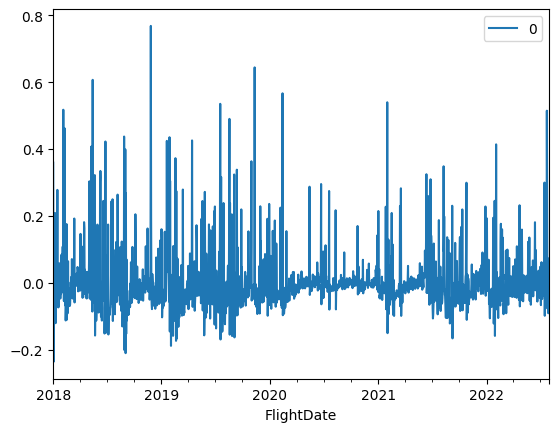

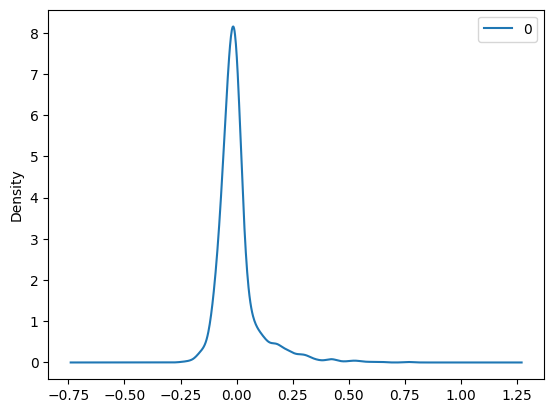

In [33]:
# Lets apply a simple ARIMA model to the Delay rate data for ORD 
from statsmodels.tsa.arima.model import ARIMA

series = ord.loc[:,'DelayRate']

# The order argument has the form (P, D, Q)
model = ARIMA(series, order=(7,2,7))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

# Outline of the Project & Paper
## 1. Explain the problem we are trying to solve -- Flight delay Forecasting
I think this is an interesting question as there are many ways to structure our target variable. One good solution could be to try and predict the Delay Rate (Delayed flights/total flights). 

## 2. Build out models 
I would consider using and ARIMA model to start and then ramp up the complexity with something like an RNN where we can incorporate more outside variables such as weather or each airline.

## 3. Further analysis
Research our problem further and apply the learned techniques and draw further conclusions. From the research I did it could be interesting to try and classify flight delay data into different statistical distributions.